In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import os
import time
import cv2
import random
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow_addons.metrics import F1Score, FBetaScore
from tensorflow_addons.callbacks import TQDMProgressBar
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, cross_val_score

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data_path = '../input/plant-pathology-2021-fgvc8'
labels_file_path = os.path.join(data_path, 'train.csv')
sample_submission_path = os.path.join(data_path, 'sample_submission.csv')
train_images_path = os.path.join(data_path, 'train_images')
test_images_path = os.path.join(data_path, 'test_images')


print(f'Label File Path: {labels_file_path}')
print(f'Sample Submission File Path: {sample_submission_path}')
print(f'Train Images Path: {train_images_path}')
print(f'Test Images Path: {test_images_path}')
      

Label File Path: ../input/plant-pathology-2021-fgvc8/train.csv
Sample Submission File Path: ../input/plant-pathology-2021-fgvc8/sample_submission.csv
Train Images Path: ../input/plant-pathology-2021-fgvc8/train_images
Test Images Path: ../input/plant-pathology-2021-fgvc8/test_images


In [4]:
train_df = pd.read_csv(labels_file_path)
train_df.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [5]:
train_df.shape

(18632, 2)

In [6]:
train_df.describe()

,image,labels
count,18632,18632
unique,18632,12
top,9585da92b9b9495a.jpg,scab
freq,1,4826


In [7]:
train_df['labels'].unique()

array(['healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'healthy'),
  Text(1, 0, 'scab frog_eye_leaf_spot complex'),
  Text(2, 0, 'scab'),
  Text(3, 0, 'complex'),
  Text(4, 0, 'rust'),
  Text(5, 0, 'frog_eye_leaf_spot'),
  Text(6, 0, 'powdery_mildew'),
  Text(7, 0, 'scab frog_eye_leaf_spot'),
  Text(8, 0, 'frog_eye_leaf_spot complex'),
  Text(9, 0, 'rust frog_eye_leaf_spot'),
  Text(10, 0, 'powdery_mildew complex'),
  Text(11, 0, 'rust complex')])

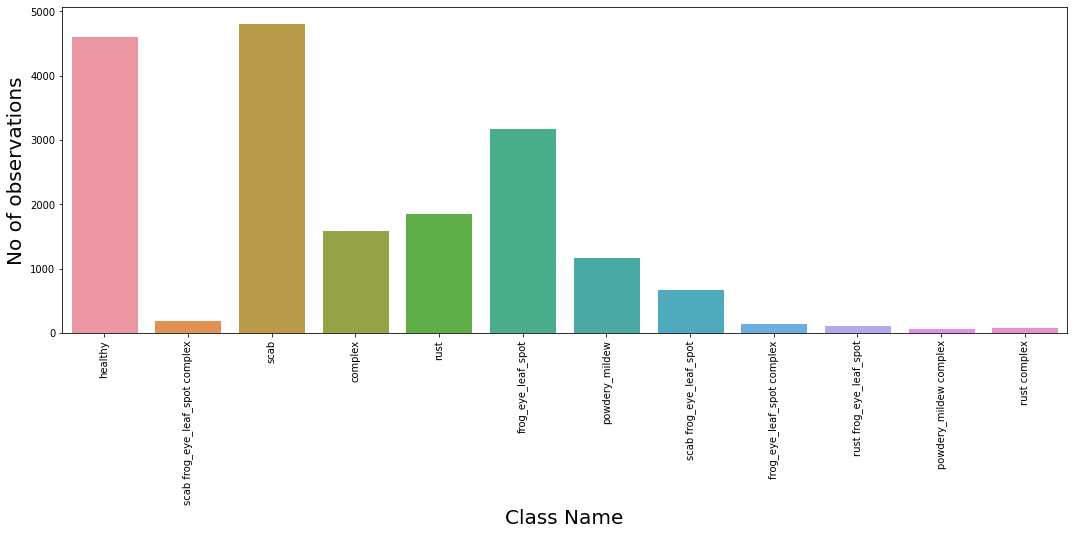

In [8]:
ax = plt.subplots(figsize = (18, 6))
sns.set_style('ticks')
sns.countplot(x = 'labels', data = train_df)
plt.ylabel('No of observations', size = 20)
plt.xlabel('Class Name', size = 20)
plt.xticks(rotation = 90)

In [14]:
BATCH = 20
IM_DIM = 380
EPOCHS = 30
IM_SHAPE = (IM_DIM, IM_DIM, 3)
LR = 1e-5

In [15]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy

In [16]:
COMPETITION_NAME = 'plant-pathology-2021-fgvc8'
strategy = auto_select_accelerator()
BATCH_SIZE = strategy.num_replicas_in_sync * BATCH
GCS_DS_PATH = KaggleDatasets().get_gcs_path('plant-pathology-2021-fgvc8')

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [17]:
df = pd.read_csv(labels_file_path)
submit_df = pd.read_csv(sample_submission_path)

In [24]:
paths = GCS_DS_PATH + '/train_images/' + df['image']
paths[0]
test_paths = GCS_DS_PATH + '/test_images/' + submit_df['image'
                                                   ]
paths[0]

'gs://kds-0edd1dccc265da75cd24056d107e8cb21280bf8a2d4aa989b3784531/train_images/800113bb65efe69e.jpg'

In [25]:
label_cols = 'labels'

le = LabelEncoder()
le.fit(df['labels'])
integer_encoded = le.transform(df['labels'])

enc = OneHotEncoder(sparse = False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = enc.fit_transform(integer_encoded)
onehot_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
(train_paths, valid_paths,
train_labels, valid_labels) = train_test_split(paths, onehot_encoded, test_size = 0.2)


In [21]:
def build_decoder(with_labels = True, target_size = (IM_DIM, IM_DIM), ext = 'jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels = 3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels = 3)
        else:
            raise ValueError('Image extension not supported')
        
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.image.resize(img, target_size)
        
        return img
    
    def decode_with_labels(path, label):
        return decode(path), label
    
    return decode_with_label if with_label else decode

In [ ]:
def build_augmenter(with_labels = True):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.70, 1.30)
        img = tf.image.random_contrast(img, 0.80, 1.20)
        img = tf.image.random_brightness(img, 0.2)
        return img
    
    def augment_with_labels(img, label):
        return augment(img), label
    
    return augment_with_labels if with_labels else augment

In [ ]:
def build_dataset(paths, labels = None, bsize = BATCH, cache = True,
                 decode_fn = None, augment_fn = None,
                 augment = True, repeat = True, shuffle = 1024,
                 cache_dir = ''):
    if cache_dir != '' and cache is True:
        os.makedirs(cache_dir, exist_ok = True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls = AUTO)
    dset = dset.cache(cache_dir) if cache else dset
    dset = dset.map(augment_fn, num_parallel_calls = AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.shuffle(shuffle) if shuffle else dset
    dset = dset.batch(bsize).prefetch(AUTO)
    
    return dset

In [ ]:
def get_model(IMG_DIM = IM_DIM, Num_Class = df['labels'].nunique()):
    with strategy.scope():
        IMG_SHAPE = (IMG_DIM. IMG_DIM, 3)
        
        feature_extractor = EfficientNetB4(input_shape = IM_SHAPE,
                                          include_top = False,
                                          drop_connect_rate = 0.2,
                                          weights = 'imagenet')
        feature_extractor.trainable = True
        
        global_average_layer = GlobalAveragePooling2D()
        dense_layer = Dense(256, activation = 'relu')
        softmax_layer = Dense(train_df['labels'].nunique(), activation = 'softmax')
        
        ap_model = Sequential([feature_extractor, global_average_layer,
                               Dropout(0.2), dense_layer, Dropout(0.2),
                               softmax_layer])
        
        ap_model.compile(optimizer = Adam(lr = LR),
                         loss = CategoricalCrossentropy(label_smoothing = 0.1),
                         metrics = [F1Score(num_classes = train_df['labels'].nunique(),
                                           average = 'macro'), 'accuracy'])
        
        ap_model.summary()
        return ap_model

In [ ]:
decoder = build_decoder(with_labels = True, target_size = (IM_DIM, IM_DIM))
test_decoder = build_decoder(with_labels = False, target_size = (IM_DIM. IM_DIM))
train_dataset = build_dataset(train_paths, train_labels, bsize = BATCH_SIZE, decode_fn = decoder)

valid_dataset = build_dataset(valid_paths, valid_labels, bsize = BATCH_SIZE,
                             decode_fn = decoder, repeat = False,
                             shuffle = False, augment = False)

test_dataset = build_dataset(test_paths, cache = False, bsize = BATCH_SIZE,
                            decode_fn = test_decoder, repeat = False,
                            shuffle = False, augment = False)


In [ ]:
STEPS_PER_EPOCH = train_paths.shape[0] // BATCH_SIZE
VALID_STEPS = valid_paths.shape[0] // BATCH_SIZE



In [ ]:
# following is another approach

18632
Index(['image', 'labels'], dtype='object')
AxesSubplot(0.125,0.125;0.775x0.755)


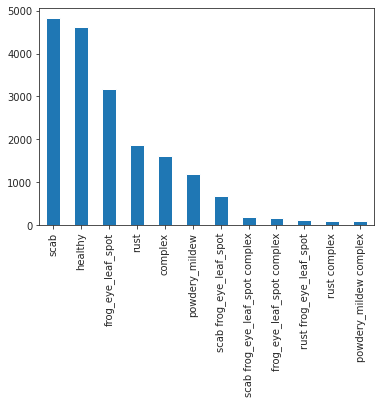

In [26]:
train = pd.read_csv('../input/plant-pathology-2021-fgvc8/train.csv')
print(len(train))
print(train.columns)
print(train['labels'].value_counts().plot.bar())

In [27]:
train['labels'] = train['labels'].apply(lambda str: str.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


In [39]:
from sklearn.preprocessing import MultiLabelBinarizer
x = list(train['labels'])
mlb = MultiLabelBinarizer()
tr = pd.DataFrame(mlb.fit_transform(x), columns = mlb.classes_, index= train.index)
print(tr.columns)
print(tr.sum())

Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64


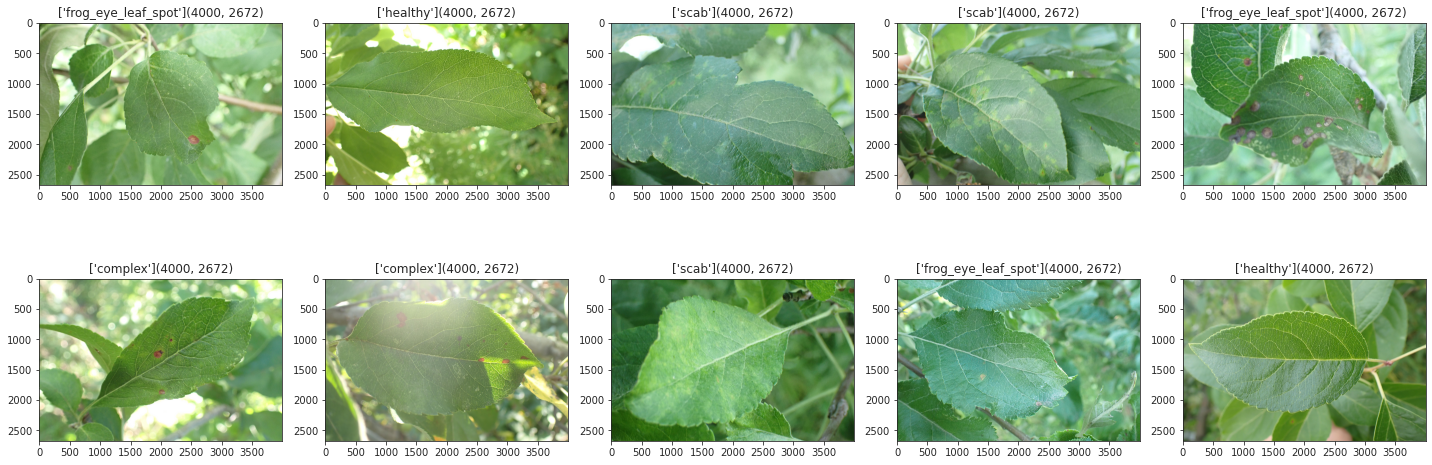

In [42]:
import PIL
fig = plt.figure(figsize = (20, 10))

for i in range(1, 11):
    ran = random.randrange(1, 18000)
    s = os.path.join('../input/plant-pathology-2021-fgvc8/train_images', train['image'][ran])
    img = PIL.Image.open(s)
    
    ax = fig.add_subplot(2, 5, i)
    ax.imshow(img)
    
    title = f"{train['labels'][ran]}{img.size}"
    plt.title(title)
    fig.tight_layout()